<img src='https://usaupload.com/cache/plugins/filepreviewer/607201/492cca2d6d223cca70571698bc3065e7b991a63d0c71e32af19a486a11d2cc42/1100x800_cropped.jpg'>

## Import tools

In [ ]:
!pip install opendatasets

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string
from string import digits
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import opendatasets as od

## Download the dataset
[Click here to learn how to download dataset via API](https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/#:~:text=Method%202%3A%20By%20easily%20downloading,folder%20to%20Google%20Colab%20Notebook.)

In [ ]:
od.download("https://www.kaggle.com/datasets/haithemhermessi/sanad-dataset")

## Load the data from directory

In [3]:
classes = os.listdir('/content/sanad-dataset') 

In [4]:
classes

['Finance', 'Sports', 'Medical', 'Tech', 'Culture', 'Politics', 'Religion']

In [5]:
def load_data():
  return tf.keras.utils.text_dataset_from_directory(
    '/content/sanad-dataset',
    labels='inferred',
    label_mode='int',
    class_names=None,
    max_length=None,
    shuffle=True)

In [6]:
dataset = load_data()

Found 45500 files belonging to 7 classes.


## Turn the dataset into DataFrame

In [105]:
x=[]
y=[]
for text_batch, label_batch in dataset:
    for i in range(len(text_batch)):
        s=text_batch.numpy()[i].decode("utf-8") 
        x.append(s)
        y.append(dataset.class_names[label_batch.numpy()[i]])
print(len(x))
print(len(y))

45500
45500


In [106]:
df = pd.DataFrame({'Article': x, 'class':y})

In [107]:
df.head()

,Article,class
0,الشارقة - عصام همام:انطلقت صباح أمس فعاليات ال...,Medical
1,تنطلق مساء اليوم من مسرح شاطئ الراحة بأبوظبي، ...,Culture
2,في إطار حرصها الدائم لتمكين عملائها من التواصل...,Tech
3,أعلنت وزارة الثقافة والشباب وتنمية المجتمع، عن...,Culture
4,دبي إيمان عبدالله: أكدت الدكتورة نجاة محمد راش...,Medical


## EDA

In [108]:
classes_counts = df['class'].value_counts()

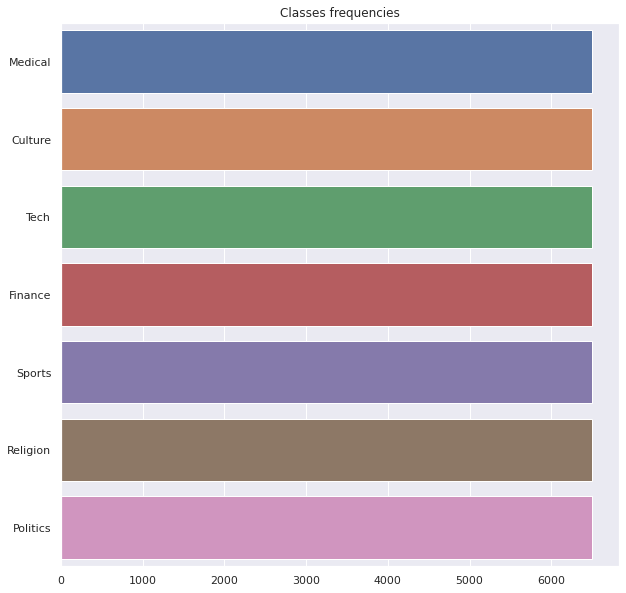

In [109]:
plt.figure(figsize=(10, 10))
plt.title("Classes frequencies")
sns.barplot(x=classes_counts.values, y=classes_counts.index)
plt.show()

<center> <h2> Conclusion: There is no class domination </<h2> <center>

## Check for nulls and secret killers

In [110]:
df.isnull().sum() / len(df) # Print percentage of NULL

Article    0.0
class      0.0
dtype: float64

In [111]:
df.duplicated().sum() / len(df)

0.00032967032967032967

### Removing the duplicates

In [112]:
df.drop_duplicates(inplace=True)

## Preprocessing and cleaning text

 Most of cleaning regex and functions are belongs to this [gist](https://github.com/motazsaad/process-arabic-text/blob/master/clean_arabic_text.py) on github

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [121]:
ara_stop_words = list(set(stopwords.words('arabic')))

In [117]:
ara_stop_words[:10]

['ث', 'سقى', 'مذ', 'جويلية', 'سنتيم', 'تاء', 'آمينَ', 'ثلاثمائة', 'أنت', 'ما']

In [118]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,،'{}~¦+«»`|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

In [122]:
# This function should delete any diacritics ' التشكيـل ' in the txt
def remove_diacritics(text):
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', str(text))
    return text

In [123]:
# This function for deleting any encoded emojis in the text
def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [124]:
# This function will remove any digits from the text
def remove_digits(txt):
  remove_digits = str.maketrans('', '', digits)
  res = txt.translate(remove_digits)
  return res

In [125]:
# Final function that make all the process
def clean_text(text):
    text = remove_emoji(text)
    text = remove_diacritics(text)
    text = remove_digits(text)
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens if word not in punctuations_list and word not in ara_stop_words])
    return text

In [126]:
# Clean the text and add it in a new pandas column, this probably will take sometime
df['articles_cln'] = df['Article'].apply(clean_text)

In [127]:
df.head()

,Article,class,articles_cln
0,الشارقة - عصام همام:انطلقت صباح أمس فعاليات ال...,Medical,الشارقة عصام همام انطلقت فعاليات المرحلة الثان...
1,تنطلق مساء اليوم من مسرح شاطئ الراحة بأبوظبي، ...,Culture,تنطلق اليوم مسرح شاطئ الراحة بأبوظبي، الحلقة ا...
2,في إطار حرصها الدائم لتمكين عملائها من التواصل...,Tech,إطار حرصها الدائم لتمكين عملائها التواصل أهلهم...
3,أعلنت وزارة الثقافة والشباب وتنمية المجتمع، عن...,Culture,أعلنت وزارة الثقافة والشباب وتنمية المجتمع، اس...
4,دبي إيمان عبدالله: أكدت الدكتورة نجاة محمد راش...,Medical,دبي إيمان عبدالله أكدت الدكتورة نجاة محمد راشد...


## Transofrm the labels into numbers

In [128]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

In [129]:
df.head()

,Article,class,articles_cln
0,الشارقة - عصام همام:انطلقت صباح أمس فعاليات ال...,2,الشارقة عصام همام انطلقت فعاليات المرحلة الثان...
1,تنطلق مساء اليوم من مسرح شاطئ الراحة بأبوظبي، ...,0,تنطلق اليوم مسرح شاطئ الراحة بأبوظبي، الحلقة ا...
2,في إطار حرصها الدائم لتمكين عملائها من التواصل...,6,إطار حرصها الدائم لتمكين عملائها التواصل أهلهم...
3,أعلنت وزارة الثقافة والشباب وتنمية المجتمع، عن...,0,أعلنت وزارة الثقافة والشباب وتنمية المجتمع، اس...
4,دبي إيمان عبدالله: أكدت الدكتورة نجاة محمد راش...,2,دبي إيمان عبدالله أكدت الدكتورة نجاة محمد راشد...


## Build the features and the model

In [130]:
X = df['articles_cln']
y = df['class']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Build sklearn pipline

In [132]:
vectorizer = TfidfVectorizer()
gaussian = MultinomialNB()
SVM = LinearSVC()

In [133]:
classifier_naive = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())])

In [134]:
classifier_naive.fit(X_train, y_train)  

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Predict with naive bayes model

In [135]:
y_pred = classifier_naive.predict(X_test)

In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1636
           1       0.99      0.93      0.96      1614
           2       0.94      0.98      0.96      1575
           3       0.97      0.97      0.97      1624
           4       0.96      0.91      0.93      1660
           5       1.00      0.99      0.99      1632
           6       0.91      0.98      0.94      1631

    accuracy                           0.96     11372
   macro avg       0.96      0.96      0.96     11372
weighted avg       0.96      0.96      0.96     11372



## Test the model

In [137]:
dataset.class_names

['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']

In [138]:
y_yest_naive = classifier_naive.predict(['الإسلام والمسيحية'])[0] 

In [140]:
label_encoder.inverse_transform([y_yest_naive])[0]

'Religion'

## Test the SVM model

In [141]:
classifier_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())])

In [142]:
classifier_svm.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [143]:
y_pred_2 = classifier_svm.predict(X_test)

In [144]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1636
           1       0.99      0.98      0.99      1614
           2       0.98      0.98      0.98      1575
           3       0.98      0.99      0.98      1624
           4       0.97      0.96      0.97      1660
           5       0.99      0.99      0.99      1632
           6       0.98      0.98      0.98      1631

    accuracy                           0.98     11372
   macro avg       0.98      0.98      0.98     11372
weighted avg       0.98      0.98      0.98     11372



<h1>The SVM look better in this case..</h1>

In [145]:
y_yest_svm = classifier_svm.predict(['الإسلام والمسيحية'])[0] 

In [146]:
label_encoder.inverse_transform([y_yest_svm])[0]

'Religion'

In [147]:
y_yest_svm_2 = classifier_svm.predict(['محمد أبو تريكة يعتبر من أشهر لاعبي كرة القدم المصرية'])[0] 

In [148]:
label_encoder.inverse_transform([y_yest_svm_2])[0]

'Sports'